In [1]:


%pylab inline
from galaxy2galaxy import problems
from astropy.visualization import make_lupton_rgb
import tensorflow as tf
Modes = tf.estimator.ModeKeys

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/G2G2/lib/python3.7/site-packages/unagi/plotting.py:30: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  IMG_CMAP.set_bad(color='black')


In [2]:
# To list the problems currently available in G2G
problems.available()



['attrs2img_cosmos',
 'attrs2img_cosmos128',
 'attrs2img_cosmos128_euclid',
 'attrs2img_cosmos32',
 'attrs2img_cosmos_psf_euclide',
 'img2img_cosmos',
 'img2img_cosmos128',
 'img2img_cosmos32',
 'img2img_cosmos_hsc',
 'img2img_hsc',
 'img2img_hsc_anomaly',
 'img2img_hsc_anomaly_small',
 'img2photoz_hsc']

In [3]:


# Let's create an instance of the hsc_problem
problem128 = problems.problem('attrs2img_cosmos_psf_euclide')

In [ ]:
def wiener_tf(image, psf, balance):
    trans_func = tf.signal.rfft2d(tf.signal.ifftshift(psf))
    wiener_filter = tf.math.conj(trans_func) / (tf.dtypes.cast(tf.math.abs(trans_func),'complex64') ** 2 + balance)
    deconv = tf.signal.irfft2d(wiener_filter * tf.signal.rfft2d(image),fft_length=image.shape)
    deconv = tf.keras.backend.clip(deconv, -1, 1)

    return deconv

def tikhonov_tf(img, psf, tau):
    if len(img.shape) == 2:
        return(wiener_tf(img, psf, tau))
    tikho_list = []
    for i in range(img.shape[0]):
        deconvolved = wiener_tf(img[i], psf[i], tau[i])
        tikho_list += [deconvolved]
    return tikho_list

In [4]:
dset = problem128.dataset(Modes.TRAIN, data_dir='/sparseastro/Euclid/ShapeDeconv/attrs2img_cosmos_psf_euclide')
dset2 = problem128.dataset(Modes.TRAIN, data_dir='/sparseastro/Euclid/ShapeDeconv/attrs2img_cosmos_psf_euclide')
#from tensorflow.compat.v1.spectral import irfft2d
def pre_proc_unet(dico):
    print(dico['inputs'].shape)
    print(dico['psf'].shape)
    dico['psf'] = tf.signal.irfft2d(tf.cast(dico['psf'], complex64)[...,0])
    print(dico['psf'].shape)
    dico['psf'] = tf.signal.fftshift(dico['psf'])
    dico['inputs'] = wiener_tf(tf.compat.v1.image.resize_image_with_pad(dico['inputs'], 128, 128)[...,0], dico['psf'], 0.05)
    dico['psf'] = tf.expand_dims(dico['psf'], axis=-1)
    dico['inputs'] = tf.expand_dims(dico['inputs'], axis=-1)
    dico['inputs'] = tf.image.crop_to_bounding_box(dico['inputs'],33,33, 64,64)
    print(dico['psf'].shape)
    print(dico['inputs'].shape)
    return dico
dset = dset.map(pre_proc_unet)

dset2 = dset2.batch(1)
dset = dset.batch(1)



INFO:tensorflow:Reading data files from /Users/hk263532/Documents/galaxy2galaxy/data/attrs2img_cosmos_psf_euclide/attrs2img_cosmos_psf_euclide-train*
INFO:tensorflow:partition: 0 num_data_files: 1
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
dset

<DatasetV1Adapter shapes: {inputs: (?, 64, 64, 1), inputs2: (?, 64, 64, 1), ps: (?, 64, 33), ps2: (?, 64, 33), psf: (?, 128, 65, 1), psf2: (?, 128, 65, 1), targets: (?, 64, 64, 1)}, types: {inputs: tf.float32, inputs2: tf.float32, ps: tf.float32, ps2: tf.float32, psf: tf.float32, psf2: tf.float32, targets: tf.float32}>

In [6]:
# Build an iterator over this dataset, and extract a batch
it = dset.make_one_shot_iterator().get_next()
it2 = dset2.make_one_shot_iterator().get_next()

sess = tf.Session()
batch = sess.run(it)
batch2 = sess.run(it2)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [7]:
type(it['inputs'])
#it.keys()

tensorflow.python.framework.ops.Tensor

IndexError: index 1 is out of bounds for axis 0 with size 1

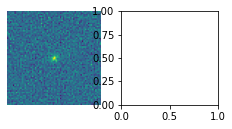

In [8]:


figure(figsize=(10,10))
for i in range(1):
    subplot(141)
    imshow(batch2['inputs'][i])
    subplot(142)
    imshow(batch['inputs2'][i])
    subplot(143)
    imshow(batch['inputs'][i])
    subplot(144)
    imshow(batch['psf'][i])
    axis('off')
    
figure(figsize=(10,10))
imshow(batch['inputs'][0])



## Test de raccordement avec le UNet

In [ ]:
def DenseBlock(n_layers, n_kernels, input_layer, activation_function='swish',
                                            axis_concat=3, concat_input=True,dilation_rate=1):
    #concat_input: implies that we have a skip concatenation between input and output of block
    connect_input = input_layer
    for n in range(n_layers):
        bn = tf.keras.layers.BatchNormalization()(connect_input)
        act = tf.keras.layers.Activation(activation_function)(bn)
        conv = tf.keras.layers.SeparableConv2D(n_kernels, 3, padding='same', use_bias=False,
                                        kernel_initializer='he_uniform')(act)
        if n == 0:
            concat = conv
        else:
            concat = tf.keras.layers.Concatenate(axis = axis_concat)([concat, conv])
        connect_input = concat
    if concat_input:
        return tf.keras.layers.Concatenate(axis = axis_concat)([input_layer, concat])
    return concat

# Define the modified U-net
img_rows = img_cols = 64
nb_scales = 4
growth_rate = 12
nb_layers_per_block = [4,5,6,7]
activation_function= 'relu'
gamma=1


inputs = tf.keras.Input(shape=(64,64,1), name="inputs")
targets = tf.keras.Input(shape=(64,64,1), name="inputs2")

#INPUT CONV
net = tf.keras.layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_initializer='he_uniform')(inputs)

#CONTRACTING PATH
skip_connect = []

for scale in range(nb_scales-1):
    block = DenseBlock(n_layers=nb_layers_per_block[scale],
                   n_kernels=growth_rate,
                   input_layer=net,
                   activation_function=activation_function,
                   concat_input=True)
    skip_connect.append(block)
    batch_norm = tf.keras.layers.BatchNormalization()(block)
    activation = tf.keras.layers.Activation(activation_function)(batch_norm)
    conv_transi = tf.keras.layers.Conv2D(32+np.sum(nb_layers_per_block[:scale+1])*growth_rate, 1, 
                         padding='same', use_bias=False, kernel_initializer='he_uniform')(activation)
    net = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv_transi)

#BOTTLENECK
block = DenseBlock(n_layers=nb_layers_per_block[-1],
                   n_kernels=growth_rate,
                   input_layer=net,
                   activation_function=activation_function,
                   concat_input=False)


#EXPANSIVE PATH
for scale in range(nb_scales-2, -1, -1):   
    up = tf.keras.layers.Conv2D(nb_layers_per_block[scale+1]*growth_rate, 2, activation = activation_function,
             padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(block))
    net = tf.keras.layers.Concatenate(axis = 3)([up, skip_connect[scale]])
    block = DenseBlock(n_layers=nb_layers_per_block[scale],
                   n_kernels=growth_rate,
                   input_layer=net,
                   activation_function=activation_function,
                   concat_input=False)

#FUSION AND SKIP CONNECT
print("chat")
batch_norm = tf.keras.layers.BatchNormalization()(block)
activation = tf.keras.layers.Activation(activation_function)(batch_norm)
outputs = tf.keras.layers.Conv2D(1, 1, activation = 'linear')(activation)
print("chien")

model = tf.keras.Model(inputs=[inputs, targets], outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3), loss = 'mse', metrics=['accuracy'])
print("ours")
history = model.fit(dset, steps_per_epoch=1,epochs=1, max_queue_size=1, shuffle= False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
chat
chien
ours
Train on 1 steps


Object `tf.keras.fit` not found.
